# Classification

This notebook builds and compares several different classifiers for a simple dataset. 

It looks at accuracy, precision, recall, F1, F1 Weighted, and MCC.

## Imports

In [1]:
# allow inline plots
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import math
import time

## Parameters

In [2]:
seed = 0
np.random.seed(seed)

mpl.rcParams['figure.figsize'] = (2.5,2.5) # default figure size, in inches
colormap = mpl.cm.get_cmap('RdYlGn') # default colormap for plots

## Get data

In [3]:
# define a simple function with 2 features and a label
# the dividing line between the labels is just y=x^2

def f(x):
    "decision boundary function"
    return x*x

def flabel(x,y):
    "label function - class 1 is above decision boundary, class 0 below"
    return int(y>f(x))

# define domain
fxmin = 0.0
fxmax = 1.0
fymin = 0.0
fymax = 1.0

In [4]:
# take random sample of points in domain and assign labels (0 or 1)

nsamples = 250

xs = np.random.rand(nsamples) * (fxmax-fxmin) + fxmin
ys = np.random.rand(nsamples) * (fymax-fymin) + fymin

labels = [flabel(x,y) for x,y in zip(xs,ys)]

In [5]:
# make a pandas dataframe with x,y,label
data = pd.DataFrame({'x':xs,'y':ys,'label':labels})
print data.head()

   label         x         y
0      1  0.548814  0.355613
1      1  0.715189  0.940432
2      1  0.602763  0.765325
3      1  0.544883  0.748664
4      1  0.423655  0.903720


## Preprocess data

In [6]:
# split data into features (X) and outcomes (y),
# which is how sklearn prefers to deal with the data.
X = data[['x','y']]
y = data['label']

In [7]:
# standardize the features -
# this subtracts the mean and divides by the standard deviation for each column.
# most learning algorithms do better with standardized values.

#. put this in a Pipeline

#from sklearn.preprocessing import StandardScaler

#stdsc = StandardScaler()
#stdsc.fit(X)
#X_std = stdsc.transform(X)
#X_std[:10]

## Show data

In [8]:
def plotData(X, y, xaxis='x', yaxis='y'):
    "plot 2d classification data"

    # split data into positive/negative samples
    positive = X[y==1]
    negative = X[y==0]

    #plt.figure(figsize=figsize)
    plt.scatter(positive[xaxis],positive[yaxis],color='g',label='positive')
    plt.scatter(negative[xaxis],negative[yaxis],color='r',label='negative')
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    xs = np.arange(fxmin, fxmax+0.1, 0.1)
    ys = f(xs)
    plt.plot(xs,ys,label='decision boundary')
    plt.xlim(fxmin-0.1,fxmax+0.1)
    plt.ylim(fymin-0.1,fymax+0.1)
    plt.grid()
    plt.legend(bbox_to_anchor=(2.5, 1))
    plt.show()

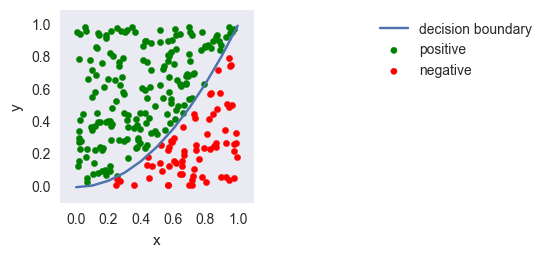

In [9]:
plotData(X, y)

## Simplest possible model

In [10]:
# the simplest model we could make from this dataset would be to 
# choose the most likely value.

def mode(a):
    "return the mode of the given list or array of integer values"
    bincounts = np.bincount(a) # eg [41 59] - ie 49 0's and 59 1's
    mode = bincounts.argmax() # index of highest value, eg 1
    return mode

most_likely_value = mode(labels)
print 'most likely value', most_likely_value

predictions = [most_likely_value] * nsamples # eg [0,0,0...]

# get an array of booleans
results = (data['label'] == predictions)

# you can actually take the mean of an array of booleans
accuracy = results.mean() 
print 'accuracy',accuracy

# that the accuracy we get here is the baseline that we need to improve on.

most likely value 1
accuracy 0.72


In [11]:
# so this is the accuracy we need to improve on

## Train a classifier

In [12]:
# now let's train a classifier on the data to get a model, 
# and use the model to make predictions.

# 1. import the classifier
from sklearn.tree import DecisionTreeClassifier

# 2. instantiate the classifier
clf_tree = DecisionTreeClassifier()

# 3. fit the data (first let's try fitting on ALL the data)
clf_tree.fit(X, y)

# 4. make a prediction
label = clf_tree.predict([[0.5,0.5]])
print label

[1]


In [13]:
# but we don't have any idea how well it's performing!

## Test/train split

In [14]:
# so let's train it on part of the data and test it on the other part.

from sklearn.cross_validation import train_test_split

# note test_size=20%, so will train on 80% of records
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [15]:
# now train the classifier on the training data
clf_tree.fit(X_train, y_train)

# make predictions on the test data
y_predict = clf_tree.predict(X_test)

# show some results
print 'actual   ',list(y_test[:20])
print 'predicted',list(y_predict[:20])

actual    [0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1]
predicted [0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]


In [16]:
# let's see if we can visualize what's going on...

## Get accuracy

In [17]:
# get an accuracy score
accuracy = (y_test==y_predict).mean()
print 'accuracy (test)',accuracy

# you can also use the score method on the classifier to get the score,
# which for this classifier is the accuracy.
# see http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#      #sklearn.tree.DecisionTreeClassifier.score
print 'accuracy (test)',clf_tree.score(X_test, y_test)

accuracy (test) 0.94
accuracy (test) 0.94


In [18]:
# so what about the training accuracy?
# ie how well does the model do against the training data that it was trained with?
print 'training accuracy',clf_tree.score(X_train, y_train)

training accuracy 1.0


In [19]:
# note that we didn't tell the decision tree what depth to use, 
# so it probably went as far as it could,
# hence should have a high training accuracy (towards 100%)

# q. since the training accuracy is so high, would you say this has high variance?
# yes, i.e. it's in the regime of overfitting - the model complexity 
# needs to be reduced in order to improve the performance of the classifier.

# q. is there a way to get a variance 'score' or bias 'score'? 
# ie something other than looking at a plot?

## Visualize the model

In [20]:
def plotDataAndModel(X, y, clf=None, title=None, xaxis='x', yaxis='y'):
    "Plot given data points and fill in background with classifier predictions"

    # fill in background with classifier predictions
    if clf:
        h = 0.025 # grid spacing

        # assign a color to each point in the mesh.
        # note: np.c_ concatenates arrays, ravel flattens 2d arrays to 1d. 
        xs = np.arange(fxmin, fxmax+h, h)
        ys = np.arange(fymin, fymax+h, h)
        xgrid, ygrid = np.meshgrid(xs, ys) # get 11x11 arrays
        grid_points = np.c_[xgrid.ravel(), ygrid.ravel()] # 121x2 array

        np.random.seed(seed)
        
        # get 2x2 array of labels or probabilities
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(grid_points)
            Z = np.where(Z>0,1,-1)
        else:
            Z = clf.predict_proba(grid_points)[:, 1]
            Z = np.where(Z>0.5,1,-1)

        # convert Z to a 2d array    
        Z = Z.reshape(xgrid.shape) 
        
        # draw the decision regions
        #plt.contourf(xs, ys, Z, cmap=colormap, alpha=0.7)   
        plt.contour(xs, ys, Z, levels=[.5], cmap="Greys", vmin=-1, vmax=1)        
    
    # draw the sample points
    # note: lw=0 prevents drawing black line around each circle
    xs = X[xaxis]
    ys = X[yaxis]
    plt.scatter(xs, ys, c=y, cmap=colormap, lw=0.0) 
    if title:
        plt.title(title)

accuracy 0.94


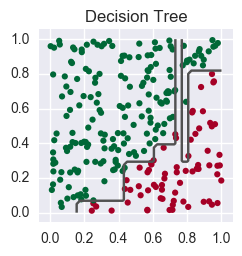

In [21]:
# plot the test points and the learned decision boundary
plotDataAndModel(X, y, clf_tree, 'Decision Tree')
print 'accuracy', clf_tree.score(X_test, y_test)

In [22]:
# note how jagged the border is - decision trees can overfit to the training data,
# causing them to not generalize well to the test data or to real world data.

## Comparing classifiers

In [23]:
# import and create classifiers
from sklearn.dummy          import DummyClassifier
from sklearn.linear_model   import LogisticRegression
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.tree           import DecisionTreeClassifier
from sklearn.svm            import SVC
from sklearn.ensemble       import RandomForestClassifier
from sklearn.ensemble       import GradientBoostingClassifier
from sklearn.ensemble       import AdaBoostClassifier
from sklearn.naive_bayes    import GaussianNB
from sklearn.linear_model   import Perceptron
#from sklearn.neural_network import MLPClassifier # Multi Layer Perceptron - in v0.18

from collections import OrderedDict
classifier_list = [
    ['Baseline',              DummyClassifier(strategy='most_frequent')],
    ['Logistic Regression',   LogisticRegression(random_state=seed)],
    ['Gaussian Naive Bayes',  GaussianNB()], # no random_state
    ['SVM (Linear)',          SVC(kernel='linear',random_state=seed)],
    ['SVM (Polynomial)',      SVC(kernel='poly',random_state=seed)],
    ['SVM (Gaussian)',        SVC(kernel='rbf',random_state=seed)], # rbf is the default kernel
    ['K-Nearest Neighbors',   KNeighborsClassifier()], # no random_state
    ['Decision Tree',         DecisionTreeClassifier(random_state=seed)],
    ['Random Forest',         RandomForestClassifier(random_state=seed)],
    ['Gradient Boosting',     GradientBoostingClassifier(random_state=seed)],
    ['AdaBoost',              AdaBoostClassifier(random_state=seed)],
    ['Perceptron',            Perceptron(random_state=seed)],
#    ['Multilayer Perceptron', MLPClassifier(solver='lbfgs',random_state=seed)],
]
classifiers = OrderedDict(classifier_list)

In [26]:
# test the baseline classifier - should be all 1's
baseline = classifiers['Baseline']
baseline.fit(X_train, y_train)
print baseline.predict(X_test)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [27]:
# import metrics
# includes accuracy, precision, f1, confusion_matrix, etc
from sklearn import metrics

In [36]:
# make a plot function
def analyzeAndPlotClassifiers(classifiers, data):
    "Fit classifiers to data, display in chart, and return results as a pandas table"
    # i put this in a function mainly so could run it all in one line - 
    # otherwise hard to see the results in one screen
    X_train, X_test, y_train, y_test = data
    plt.figure(figsize=(12,9))
    rows = []
    columns = ['Classifier','Accuracy','Precision','Recall','F1','F1 weighted','MCC']
    iplot = 1
    for classifier_name, clf in classifiers.items():
    
        # train model
        clf.fit(X_train, y_train)
        
        # predict labels
        y_predict = clf.predict(X_test)
        
        # plot data
        plt.subplot(3,4,iplot)
        plotDataAndModel(X_train, y_train, clf, classifier_name)
        #plotDataAndModel(X_test, y_test, clf, classifier_name)
        iplot += 1

        # get metrics
        accuracy    = metrics.accuracy_score(y_test, y_predict)
        precision   = metrics.precision_score(y_test, y_predict)
        recall      = metrics.recall_score(y_test, y_predict)
        f1          = metrics.f1_score(y_test, y_predict)
        f1_weighted = metrics.f1_score(y_test, y_predict, average='weighted', pos_label=None)
        mcc         = metrics.matthews_corrcoef(y_test, y_predict)

        # add results to table
        row = [classifier_name, accuracy, precision, recall, f1, f1_weighted, mcc]
        rows.append(row)
        
    plt.tight_layout()
    #plt.suptitle('Decision Boundaries for Different Classifiers') # runs into other titles

    results = pd.DataFrame(rows, columns=columns)
    return results

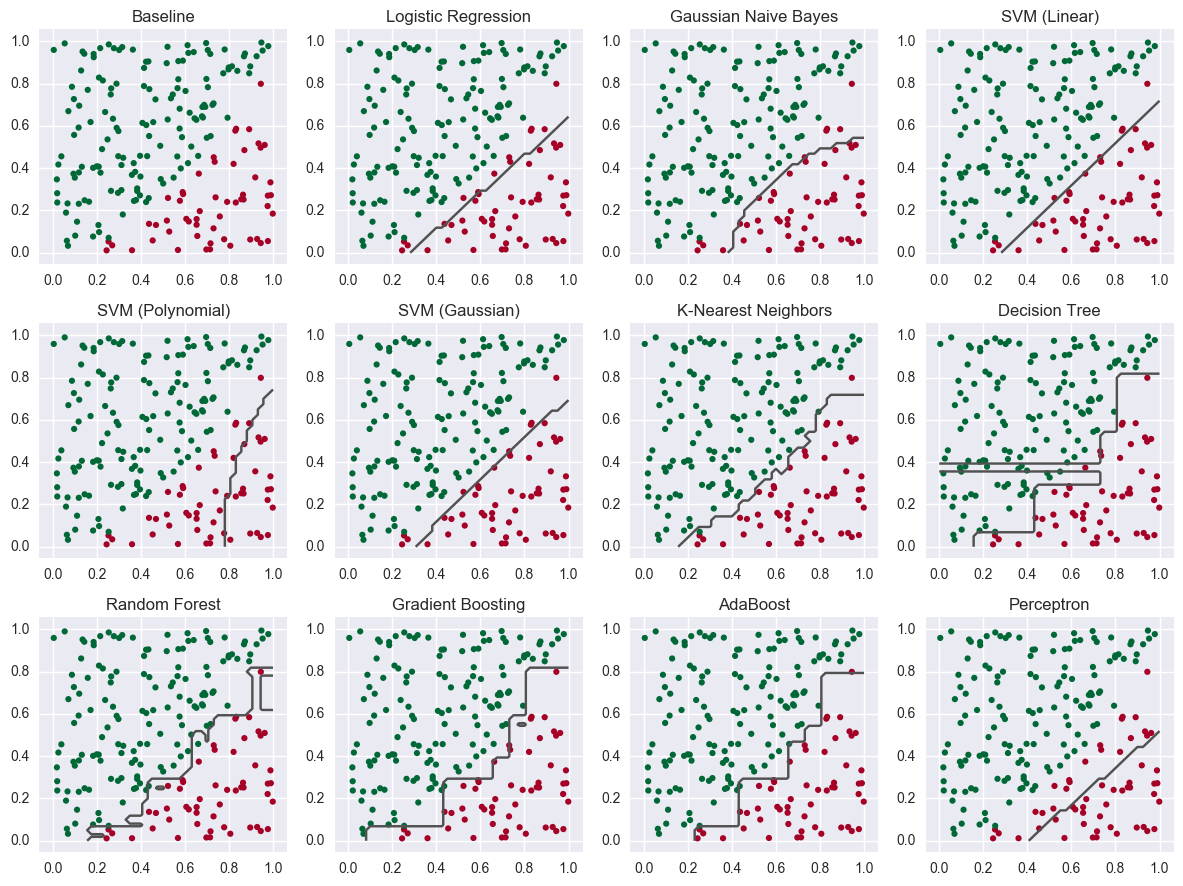

In [37]:
# show training data and decision boundaries
data = (X_train, X_test, y_train, y_test)
results = analyzeAndPlotClassifiers(classifiers, data)

In [30]:
# q. why do some of these fit so badly, with such a simple problem?
# (eg Perceptron, Polynomial SVM)
# need to standardize features before training?

In [31]:
# show results, sorted by MCC
results.sort('MCC',ascending=False)

,Classifier,Accuracy,Precision,Recall,F1,F1 weighted,MCC
7,Decision Tree,0.98,0.972222,1.000000,0.985915,0.979796,0.952579
9,Gradient Boosting,0.98,0.972222,1.000000,0.985915,0.979796,0.952579
10,AdaBoost,0.98,0.972222,1.000000,0.985915,0.979796,0.952579
6,K-Nearest Neighbors,0.94,0.921053,1.000000,0.958904,0.937900,0.858395
2,Gaussian Naive Bayes,0.92,0.897436,1.000000,0.945946,0.916008,0.811246
3,SVM (Linear),0.92,0.897436,1.000000,0.945946,0.916008,0.811246
5,SVM (Gaussian),0.92,0.897436,1.000000,0.945946,0.916008,0.811246
8,Random Forest,0.92,0.918919,0.971429,0.944444,0.918254,0.805940
1,Logistic Regression,0.90,0.875000,1.000000,0.933333,0.893333,0.763763
11,Perceptron,0.86,0.833333,1.000000,0.909091,0.845059,0.666667


So the top 3, for this very clean/non-noisy data, are Decision Tree, Gradient Boosting, and AdaBoost.

MCC is the Matthews Correlation Coefficient, which tries to balance all four numbers of the confusion matrix. 

> The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary (two-class) classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction.

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html

Note that the Baseline classifier has an MCC score of 0.0, which indicates random guessing. 